In [1]:
from cpymad.madx import Madx
import xtrack as xt
import numpy as np
import bpmeth
import matplotlib.pyplot as plt

### ELENA lattice from MAD-X

In [2]:
madx = Madx()

madx.call("acc-models-elena/elena.seq")
#   Apertures:
madx.call("acc-models-elena/elena.dbx")
#   Split elements to allow inserting BPMs:
madx.call("acc-models-elena/tools/splitEle_installBPM.madx")
# call strenghts for a given scenario
madx.call("acc-models-elena/scenarios/highenergy/highenergy.str")
# define beam
madx.call("acc-models-elena/scenarios/highenergy/highenergy.beam")

madx.use("elena")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.07.17 14:29:10      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ELENA ring Sequence -> LNR

!

!

! Changelog:

! -  5/06/2018: started with Pavel''s optics

!   - cleaned up some commented lines and added some markers

!   - redefined randomly some names of the e-cool solenoids

!   - TODO: 

!      - cleanup useless lines. re-arrange markers "badly" used here and there.

!      - rename non-existing quad 631 and 626 !!!

! - 24/11/2020: adjusted structure to new standards. Still a lot of work to do to make it LDB compatible.

! - Sep 2021: moving toward LDB-compatible model

!

! TODO: probably need to work on arc lenght for dipoles to match GEODE/drawings/LDB.





/************************************************************************************/

/*            

In [3]:
line = xt.Line.from_madx_sequence(madx.sequence.elena)
line.particle_ref = xt.Particles(p0c=0.1, mass0=0.938272, q0=1)

bend_fint = line["lnr.mbhek.0640.h2"].edge_exit_fint
print(f"Fringe field integral in lattice: {bend_fint}")

tw = line.twiss4d()

Converting sequence "elena":   0%|          | 0/191 [00:00<?, ?it/s]

Fringe field integral in lattice: 0.424


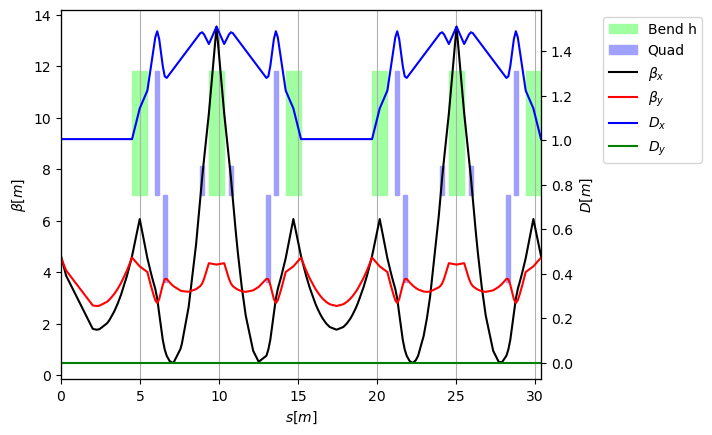

In [4]:
tw.plot()

### Numerical ELENA dipole

In [5]:
rho = 0.927
phi = 60/180*np.pi
l_magn = rho*phi
apt = 0.076
hgap = apt/2
theta_E = line["lnr.mbhek.0640.h2"].edge_exit_angle
B = 5.3810e-07
Brho = B*rho
design_field=1/rho*1.001803

In [6]:
data = np.loadtxt("../dipole/ELENA_fieldmap.csv", skiprows=1, delimiter=",")[:, [0,1,2,7,8,9]]

Fitting multipoles
fitting b1...
fitting b2...
Central field in the magnet:  1.0905829520748025
Average field in the magnet:  1.0840169060067997
Rescaling field to match integrated field with design field
Central field in the magnet:  1.0872395519235576
Average field in the magnet:  1.0806936353829557
Creating field expansion...
Creating Hamiltonian...


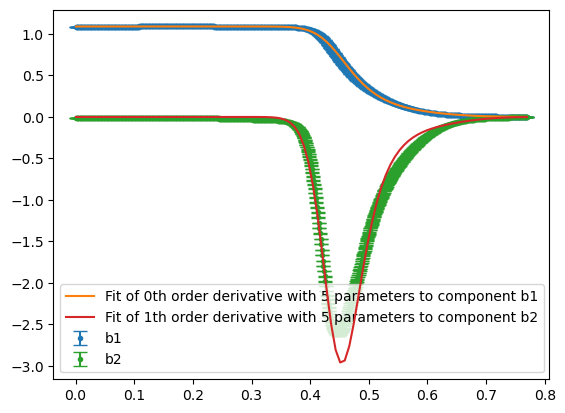

In [7]:
guess = [ 1.09058298e+00, 3.19608461e+02, -1.03315497e+02, 2.80836370e+01, 4.23617617e-01]
dipole = bpmeth.DipoleFromFieldmap(data, 1/rho, l_magn, design_field=design_field, shape="enge", hgap=apt/2, apt=apt, radius=0.0025, order=2, plot=True, nphi=2, guess=guess)

Fitting multipoles


/home/silke/Documents/repositories/src/bpmeth/fieldmaps.py:423: RuntimeWarning: invalid value encountered in divide
  bp = np.nan_to_num(np.diff(b,prepend=b[0])/dz, copy=True)


Creating field expansion...
Creating Hamiltonian...


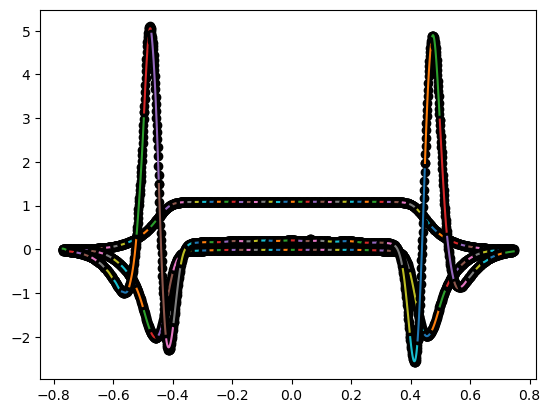

In [8]:
dipole_splines = bpmeth.MagnetFromFieldmap(data, 1/rho, l_magn, design_field=1/rho, order=3, hgap=apt/2, nphi=2, plot=True, step=25)

In [11]:
ss = np.linspace(0, dipole.smax, 1000)
print("Quadrupole from integral from fieldmap rescaled with correct integrated dipole field: ", dipole.fieldmap.integratedfield(3, zmin=0)[1])
print("Quadrupole from integral for fit with enge derivative: ", np.trapezoid([dipole.b_out[1].subs({dipole.s:sss}) for sss in ss], ss))
print("Quadrupole component in xsuite: ", -1/rho*np.tan(theta_E))
print("Theta from fieldmap integrated field: ", np.arctan(-rho*(dipole.fieldmap.integratedfield(3, zmin=0)[1]))*180/np.pi)


Quadrupole from integral from fieldmap rescaled with correct integrated dipole field:  -0.28373831419788503
Quadrupole from integral for fit with enge derivative:  -0.284621636109274
Quadrupole component in xsuite:  -0.31851618736281756
Theta from fieldmap integrated field:  14.736463811057279


### Lattice without edge angles in first magnet

In [11]:
line2 = xt.Line.from_madx_sequence(madx.sequence.elena,deferred_expressions=True)
line2.particle_ref = xt.Particles(p0c=0.1, mass0=0.938272, q0=1)
line2.configure_bend_model(core='adaptive', edge='full')
tw = line2.twiss4d()
print(f"{tw.qx}")
print(f"{tw.qy}")

res = {'lnr_kq1': 2.813705672068076, 'lnr_kq2': -2.0918538880765594, 'lnr_kq3': 0.38836923739266527}
for k,v in res.items():
    line2.vars[k]=v

line2['lnr.mbhek.0135.h1'].edge_entry_fint=0.0
line2['lnr.mbhek.0135.h2'].edge_exit_fint=0.0
line2['lnr.mbhek.0135.h1'].edge_entry_angle=0.0
line2['lnr.mbhek.0135.h2'].edge_exit_angle=0.0

Converting sequence "elena":   0%|          | 0/191 [00:00<?, ?it/s]

2.3616898448610883
1.3899257304100336


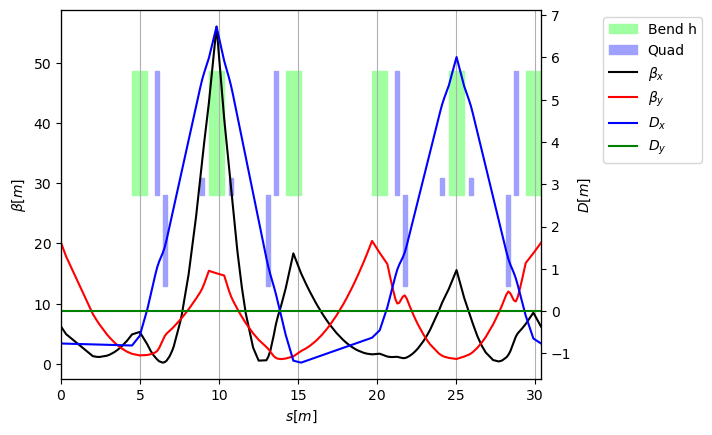

In [12]:
line2.twiss4d().plot()

### Replace a dipole

In [13]:
tab = line.get_table()
tab.show(cols=['s_start', 's_center', 's_end'])

name                          s_start      s_center         s_end
elena$start                         0             0             0
lnr.startsurvey                     0             0             0
lnr.begin                           0             0             0
section1$start                      0             0             0
drift_0                             0        0.1603        0.3206
lnr.mccay.0105                 0.3206        0.3206        0.3206
lnr.bpmeb.0110                 0.3206        0.3206        0.3206
drift_1                        0.3206       1.16575        2.0109
lnr.vvgbf.0114                 2.0109        2.0109        2.0109
drift_2                        2.0109       2.13025        2.2496
lnr.mmidinj                    2.2496        2.2496        2.2496
drift_3                        2.2496        2.3396        2.4296
lnr.mbmie.0115                 2.4296        2.4296        2.4296
drift_4                        2.4296       2.66905        2.9085
lnr.btvpa.

In [14]:
k1_edge = -line["lnr.mbhek.0135.h1"].k0*np.tan(line["lnr.mbhek.0135.h1"].edge_entry_angle)
dipole_s = line.get_s_position(at_elements="lnr.mbhek.0135.m")
dipole_len = line["lnr.mbhek.0135.h1"].length+line["lnr.mbhek.0135.h2"].length
dipole_k0 = line["lnr.mbhek.0135.h1"].k0
dipole_h = line["lnr.mbhek.0135.h1"].h

In [15]:
theta_E*180/np.pi

np.float64(16.45)

In [16]:
# Run this if you want to have an approximate tanh model (not even fitted)
# extent=0.2
# slope = 0.05

# dipole_A_in_str = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0} * (tanh((s+{dipole_len/2})/{slope})+1)/2", curv=0)
# dipole_A_in_curv = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0} * (tanh((s+{dipole_len/2})/{slope})+1)/2", curv=dipole_h)
# dipole_A_out_str = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0} * (tanh(-(s-{dipole_len/2})/{slope})+1)/2", curv=0)
# dipole_A_out_curv = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0} * (tanh(-(s-{dipole_len/2})/{slope})+1)/2", curv=dipole_h)

# dipole_H_in_str = bpmeth.Hamiltonian(extent, 0, dipole_A_in_str, s_start=-extent-dipole_len/2)
# dipole_H_in_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, dipole_A_in_curv, s_start=-dipole_len/2)
# dipole_H_out_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, dipole_A_out_curv, s_start=0)
# dipole_H_out_str = bpmeth.Hamiltonian(extent, 0, dipole_A_out_str, s_start=dipole_len/2)


In [17]:
# Run this for the dipole from ELENA
extent = (dipole.smax - dipole.smin - dipole_len)/2

dipole_A_in_str = bpmeth.GeneralVectorPotential(b=(dipole.b_in[0],), hs="0", nphi=2)
dipole_A_in_curv = bpmeth.GeneralVectorPotential(b=(dipole.b_in[0],), hs=f"{dipole_h}", nphi=2)
dipole_A_out_str = bpmeth.GeneralVectorPotential(b=(dipole.b_out[0],), hs="0", nphi=2)
dipole_A_out_curv = bpmeth.GeneralVectorPotential(b=(dipole.b_out[0],), hs=f"{dipole_h}", nphi=2)

dipole_H_in_str = bpmeth.Hamiltonian(extent, 0, dipole_A_in_str, s_start=-extent-dipole_len/2)
dipole_H_in_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, dipole_A_in_curv, s_start=-dipole_len/2)
dipole_H_out_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, dipole_A_out_curv, s_start=0)
dipole_H_out_str = bpmeth.Hamiltonian(extent, 0, dipole_A_out_str, s_start=dipole_len/2)

In [18]:
# Only dipole component and without derivatives
only_dipole_A_in_str = bpmeth.DipoleVectorPotential(b1=dipole.b_in[0], curv=0)
only_dipole_A_in_curv = bpmeth.DipoleVectorPotential(b1=dipole.b_in[0], curv=dipole_h)
only_dipole_A_out_str = bpmeth.DipoleVectorPotential(b1=dipole.b_out[0], curv=0)
only_dipole_A_out_curv = bpmeth.DipoleVectorPotential(b1=dipole.b_out[0], curv=dipole_h)

only_dipole_H_in_str = bpmeth.Hamiltonian(extent, 0, only_dipole_A_in_str, s_start=-extent-dipole_len/2)
only_dipole_H_in_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, only_dipole_A_in_curv, s_start=-dipole_len/2)
only_dipole_H_out_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, only_dipole_A_out_curv, s_start=0)
only_dipole_H_out_str = bpmeth.Hamiltonian(extent, 0, only_dipole_A_out_str, s_start=dipole_len/2)

1.08816532471434/(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1)
-1.08816532471434*x/(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1)
1.08816532471434/(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1)
1.08816532471434*(-0.539374325782093*x**2 - x)/((1.07874865156419*x + 1)*(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1))
1.08816532471434/(2.65519798584688e-6*exp(27.3647087115595*s + 403.598189374322*(s - 0.485376064979623)**3 - 109.892046754963*(s - 0.485376064979623)**2) + 1)
1.08816532471434*(-0.539374325782093*x**2 - x)/((1.07874865156419*x + 1)*(2.65519798584688e-6*exp(27.3647087115595*s + 403.5981893743

In [19]:
dipole_A_full = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0}", curv=dipole_h)
dipole_H_full = bpmeth.Hamiltonian(dipole_len, dipole_h, dipole_A_full)

1.0787486515641855
1.07874865156419*(-0.539374325782093*x**2 - x)/(1.07874865156419*x + 1)


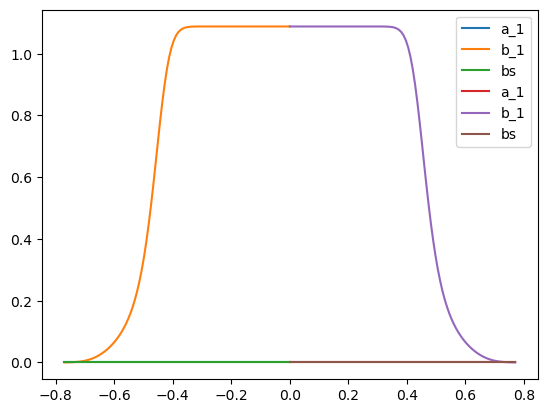

In [20]:
fig, ax = plt.subplots()
dipole_A_in_str.plot_components(ax=ax, smin=dipole.smin, smax=0)
dipole_A_out_str.plot_components(ax=ax, smin=0, smax=dipole.smax)


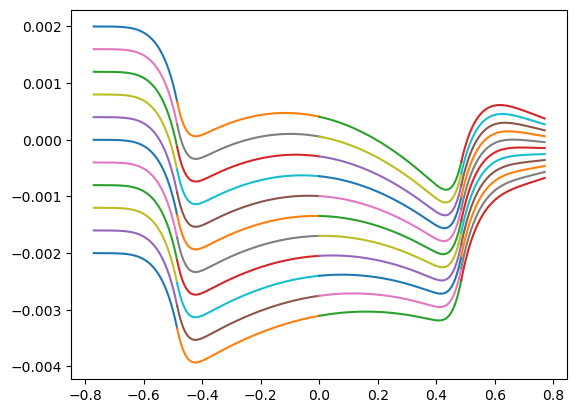

In [21]:
import xtrack as xt
p = xt.Particles(x=np.linspace(-2e-3, 2e-3, 11), y=np.linspace(-2e-3, 2e-3, 11), p0c=0.1, mass0=0.938272, q0=1)

sol_1 = dipole_H_in_str.track(p, return_sol=True)
sol_2 = dipole_H_in_curv.track(p, return_sol=True)
sol_3 = dipole_H_out_curv.track(p, return_sol=True)
sol_4 = dipole_H_out_str.track(p, return_sol=True)

fig, ax = plt.subplots()
for i, _ in enumerate(p.x):
    ax.plot(sol_1[i].t, sol_1[i].y[0])
    ax.plot(sol_2[i].t, sol_2[i].y[0])
    ax.plot(sol_3[i].t, sol_3[i].y[0])
    ax.plot(sol_4[i].t, sol_4[i].y[0])

In [22]:
line_mydipole = line2.copy()

line_mydipole.remove("lnr.mbhek.0135.h1")
line_mydipole.remove("lnr.mbhek.0135.m")
line_mydipole.remove("lnr.mbhek.0135.h2")

line_mydipole.insert("mydipole1", dipole_H_in_str, at=dipole_s - dipole_len/2 - extent/2)
line_mydipole.insert("mydipole2", dipole_H_in_curv, at=dipole_s - dipole_len/4)
line_mydipole.insert("mydipole3", dipole_H_out_curv, at=dipole_s + dipole_len/4)
line_mydipole.insert("mydipole4", dipole_H_out_str, at=dipole_s + dipole_len/2 + extent/2)

Slicing line:   0%|          | 0/198 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

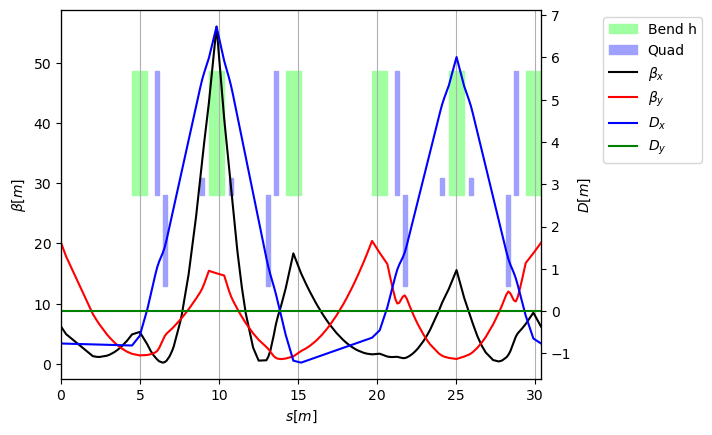

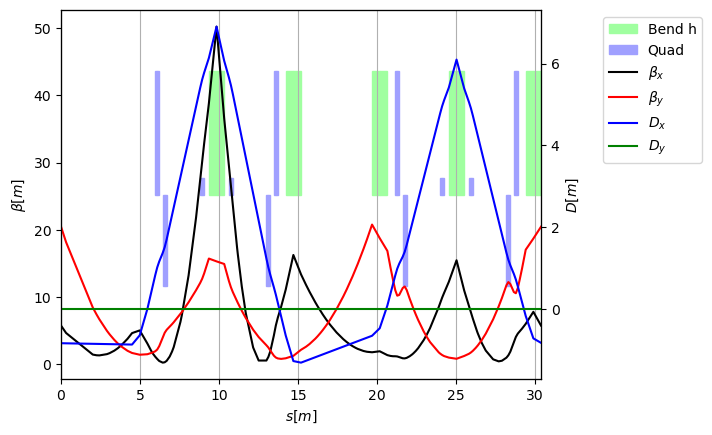

In [23]:
tw2 = line2.twiss4d()
tw_mydipole = line_mydipole.twiss4d(include_collective=True)
# tw_mydipole = line_mydipole.twiss4d(betx=tw2.betx[0], bety=tw2.bety[0], alfx=tw2.alfx[0], alfy=tw2.alfy[0], dx=tw2.dx[0], dpx=tw2.dpx[0], include_collective=True)
tw2.plot()
tw_mydipole.plot()

In [24]:
line_with_fint = line2.copy()
line_with_fint["lnr.mbhek.0135.h1"].edge_entry_fint = line["lnr.mbhek.0135.h1"].edge_entry_fint
line_with_fint["lnr.mbhek.0135.h2"].edge_exit_fint = line["lnr.mbhek.0135.h2"].edge_exit_fint

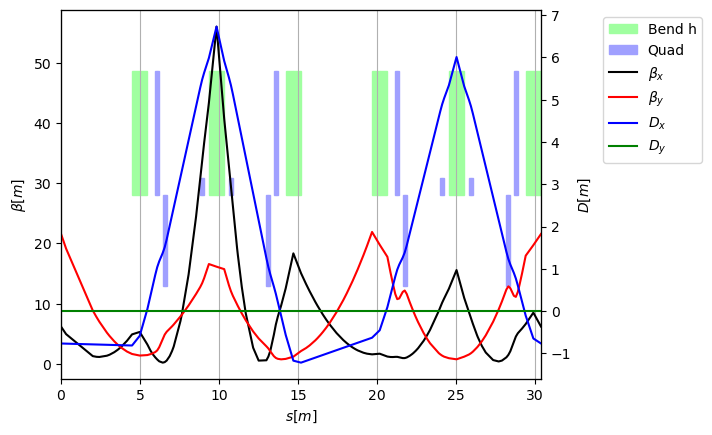

In [25]:
tw_with_fint = line_with_fint.twiss4d()
tw_with_fint.plot()

In [26]:
line_only_dipole = line2.copy()

line_only_dipole.remove("lnr.mbhek.0135.h1")
line_only_dipole.remove("lnr.mbhek.0135.m")
line_only_dipole.remove("lnr.mbhek.0135.h2")

line_only_dipole.insert("mydipole1", only_dipole_H_in_str, at=dipole_s - dipole_len/2 - extent/2)
line_only_dipole.insert("mydipole2", only_dipole_H_in_curv, at=dipole_s - dipole_len/4)
line_only_dipole.insert("mydipole3", only_dipole_H_out_curv, at=dipole_s + dipole_len/4)
line_only_dipole.insert("mydipole4", only_dipole_H_out_str, at=dipole_s + dipole_len/2 + extent/2)


Slicing line:   0%|          | 0/198 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

In [27]:
tw_only_dipole = line_only_dipole.twiss4d(include_collective=True)

1.08816532471434/(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1)
-1.08816532471434*x/(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1)
1.08816532471434/(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1)
-1.08816532471434*x/(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1)
1.08816532471434/(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*(-s - 0.485376064979623)**2) + 1)
1.08816532471434*(-0.539374325782093*x**2 - x)/((1.07874865156419*x + 1)*(2.65519798584688e-6*exp(-27.3647087115595*s + 403.598189374322*(-s - 0.485376064979623)**3 - 109.892046754963*

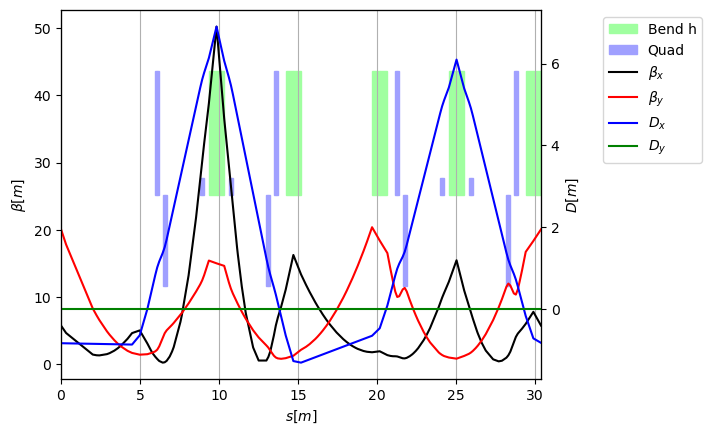

In [28]:
tw_only_dipole.plot()

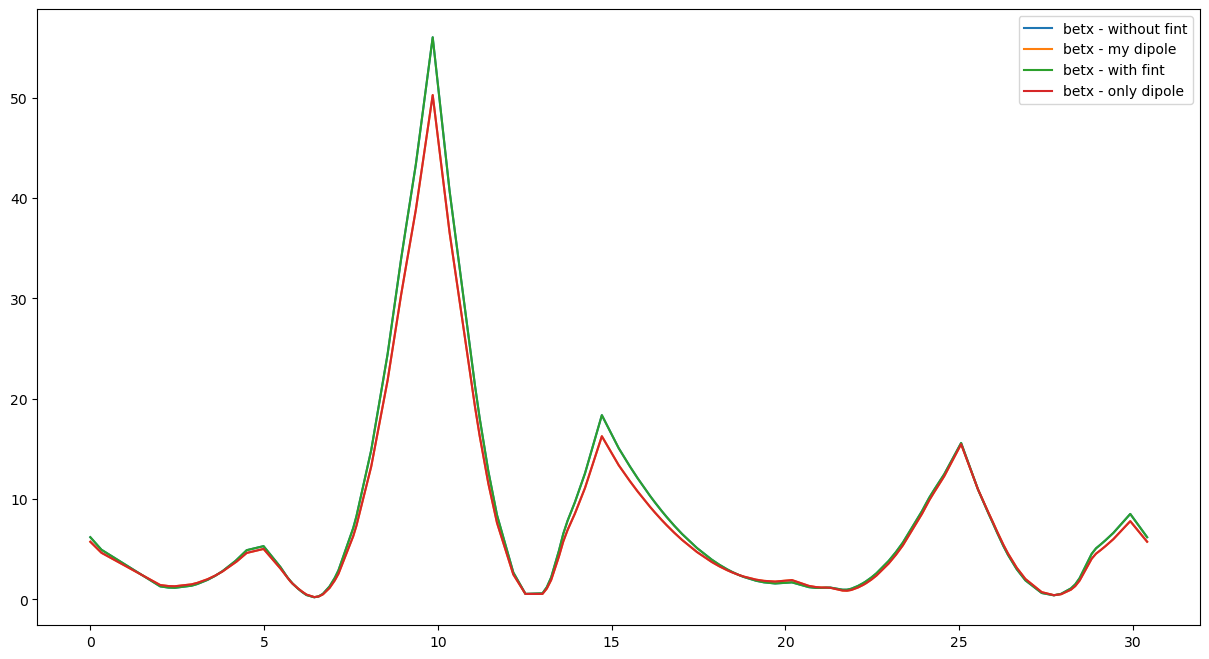

In [29]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(tw2.s, tw2.betx, label='betx - without fint')
ax.plot(tw_mydipole.s, tw_mydipole.betx, label='betx - my dipole')
ax.plot(tw_with_fint.s, tw_with_fint.betx, label='betx - with fint')
ax.plot(tw_only_dipole.s, tw_only_dipole.betx, label='betx - only dipole')
plt.legend()

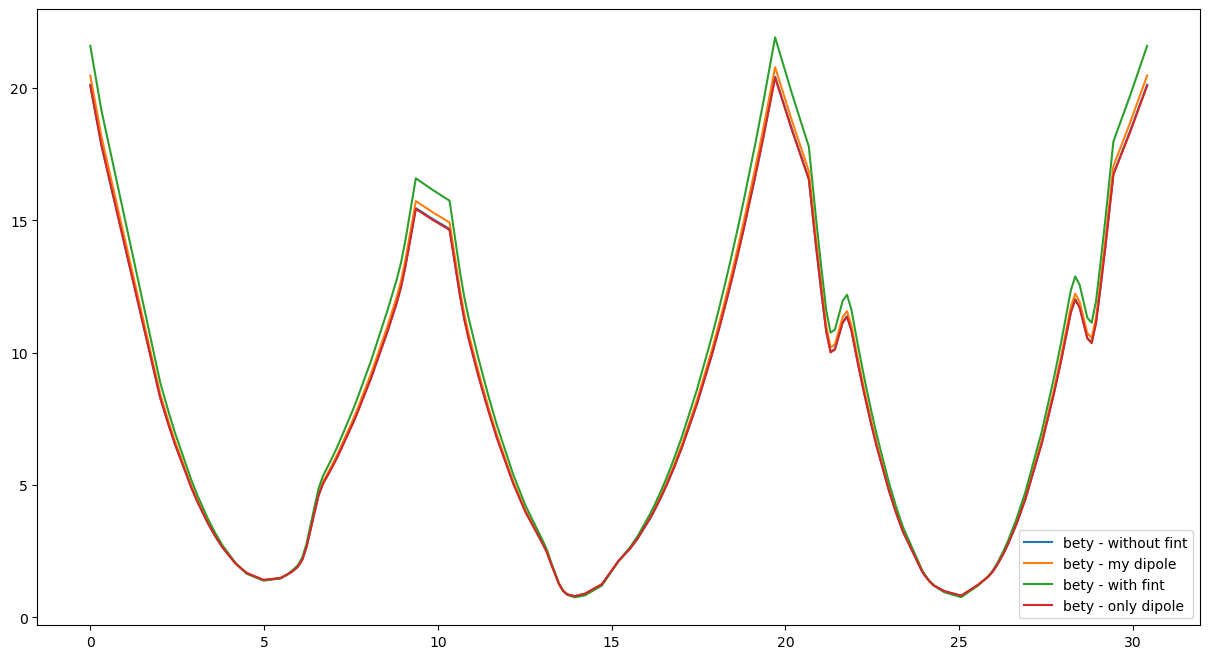

In [30]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(tw2.s, tw2.bety, label='bety - without fint')
ax.plot(tw_mydipole.s, tw_mydipole.bety, label='bety - my dipole')
ax.plot(tw_with_fint.s, tw_with_fint.bety, label='bety - with fint')
ax.plot(tw_only_dipole.s, tw_only_dipole.bety, label='bety - only dipole')
plt.legend()

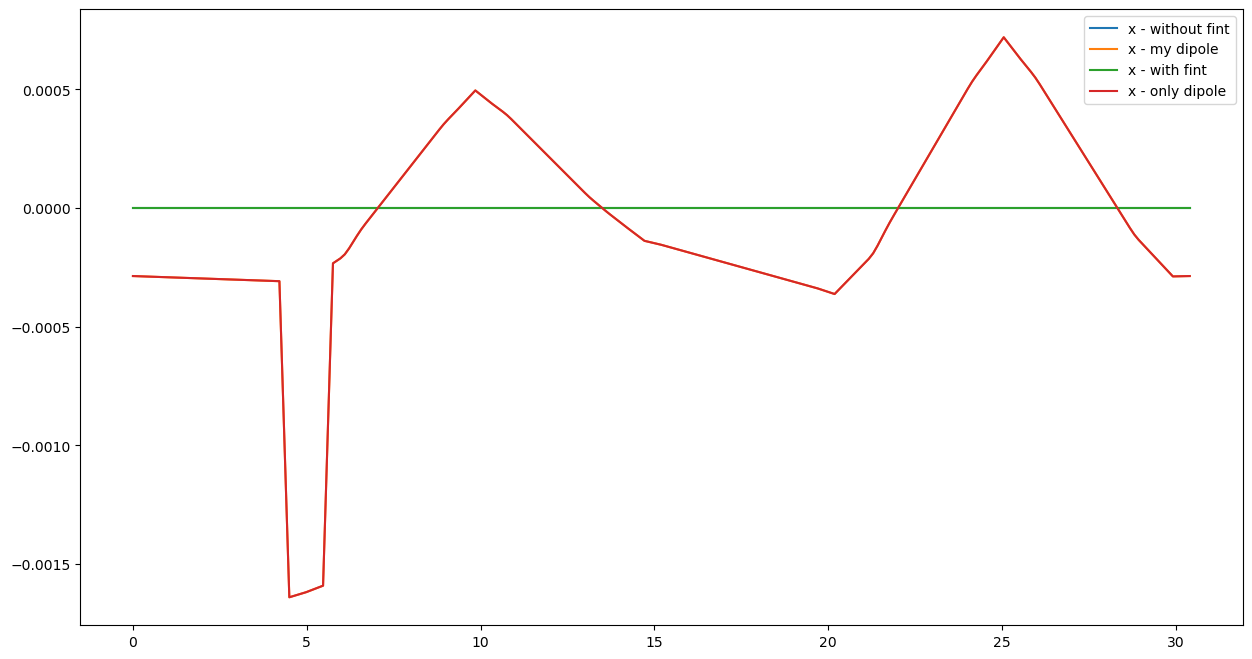

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(tw2.s, tw2.x, label='x - without fint')
ax.plot(tw_mydipole.s, tw_mydipole.x, label='x - my dipole')
ax.plot(tw_with_fint.s, tw_with_fint.x, label='x - with fint')
ax.plot(tw_only_dipole.s, tw_only_dipole.x, label='x - only dipole')
plt.legend()

### Not rematched 

In [32]:
circum = line.get_s_position(at_elements="elena$end")

In [ ]:
line_not_rematched_mydipole = line.copy()
line_not_rematched_without_fint = line.copy()

for dipolename in ["lnr.mbhek.0135", "lnr.mbhek.0245", "lnr.mbhek.0335", "lnr.mbhek.0470", "lnr.mbhek.0560", "lnr.mbhek.0640"]:
    dipole_s = line.get_s_position(at_elements=dipolename+".m")
    print(dipolename, dipole_s)

    line_not_rematched_mydipole.remove(dipolename+".h1")
    line_not_rematched_mydipole.remove(dipolename+".m")
    line_not_rematched_mydipole.remove(dipolename+".h2")
    line_not_rematched_mydipole.insert(dipolename+"mydipole1", dipole_H_in_str, at=(dipole_s - dipole_len/2 - extent/2)%circum)
    line_not_rematched_mydipole.insert(dipolename+"mydipole2", dipole_H_in_curv, at=(dipole_s - dipole_len/4)%circum)
    line_not_rematched_mydipole.insert(dipolename+"mydipole3", dipole_H_out_curv, at=(dipole_s + dipole_len/4)%circum)
    line_not_rematched_mydipole.insert(dipolename+"mydipole4", dipole_H_out_str, at=(dipole_s + dipole_len/2 + extent/2)%circum)

    line_not_rematched_mydipole.insert(dipolename+"entrance_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s-dipole_len/2)
    line_not_rematched_mydipole.insert(dipolename+"exit_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s+dipole_len/2)

    # To compare: line without fringes, with quadrupoles to replace edges
    line_not_rematched_without_fint[dipolename+".h1"].edge_entry_fint = 0
    line_not_rematched_without_fint[dipolename+".h2"].edge_exit_fint = 0

    line_not_rematched_without_fint[dipolename+".h1"].edge_entry_angle = 0
    line_not_rematched_without_fint[dipolename+".h2"].edge_exit_angle = 0

    line_not_rematched_without_fint.insert(dipolename+"entrance_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s-dipole_len/2)
    line_not_rematched_without_fint.insert(dipolename+"exit_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s+dipole_len/2)


lnr.mbhek.0135 4.984576064979623


Slicing line:   0%|          | 0/198 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/201 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/202 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/200 [00:00<?, ?it/s]

lnr.mbhek.0245 9.850928194938867


Slicing line:   0%|          | 0/202 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/203 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/203 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/203 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/204 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/205 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/201 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/202 [00:00<?, ?it/s]

lnr.mbhek.0335 14.717280324898109


Slicing line:   0%|          | 0/205 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/206 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/206 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/206 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/207 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/208 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/203 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/204 [00:00<?, ?it/s]

lnr.mbhek.0470 20.187232454857348


Slicing line:   0%|          | 0/208 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/209 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/209 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/209 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/211 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/212 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/205 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/206 [00:00<?, ?it/s]

lnr.mbhek.0560 25.053584584816594


Slicing line:   0%|          | 0/212 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/213 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/213 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/213 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/214 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/215 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/207 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/208 [00:00<?, ?it/s]

lnr.mbhek.0640 29.91993671477584


Slicing line:   0%|          | 0/215 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/217 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/217 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/217 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/218 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/219 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/209 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/210 [00:00<?, ?it/s]

In [41]:
tab_not_rematched_mydipole = line_not_rematched_mydipole.get_table()
tab_not_rematched_mydipole.show(cols=['s_start', 's_center', 's_end'])

name                                   s_start      s_center         s_end
elena$start                                  0             0             0
lnr.startsurvey                              0             0             0
lnr.begin                                    0             0             0
section1$start                               0             0             0
lnr.mbhek.0640mydipole4                      0        0.1425         0.285
drift_0..1                               0.285        0.3028        0.3206
lnr.mccay.0105                          0.3206        0.3206        0.3206
lnr.bpmeb.0110                          0.3206        0.3206        0.3206
drift_1                                 0.3206       1.16575        2.0109
lnr.vvgbf.0114                          2.0109        2.0109        2.0109
drift_2                                 2.0109       2.13025        2.2496
lnr.mmidinj                             2.2496        2.2496        2.2496
drift_3                  

In [42]:
tab_not_rematched_without_fint = line_not_rematched_without_fint.get_table()
tab_not_rematched_without_fint.show(cols=['s_start', 's_center', 's_end'])

name                                   s_start      s_center         s_end
elena$start                                  0             0             0
lnr.startsurvey                              0             0             0
lnr.begin                                    0             0             0
section1$start                               0             0             0
drift_0                                      0        0.1603        0.3206
lnr.mccay.0105                          0.3206        0.3206        0.3206
lnr.bpmeb.0110                          0.3206        0.3206        0.3206
drift_1                                 0.3206       1.16575        2.0109
lnr.vvgbf.0114                          2.0109        2.0109        2.0109
drift_2                                 2.0109       2.13025        2.2496
lnr.mmidinj                             2.2496        2.2496        2.2496
drift_3                                 2.2496        2.3396        2.4296
lnr.mbmie.0115           

In [48]:
tw_not_rematched_mydipole=line_not_rematched_mydipole.twiss4d(betx=tw.betx[0], bety=tw.bety[0], alfx=tw.alfx[0], alfy=tw.alfy[0], dx=tw.dx[0], dy=tw.dy[0], x=0, y=0, include_collective=True)
# tw4=line4.twiss4d()
tw_not_rematched_without_fint=line_not_rematched_without_fint.twiss4d(betx=tw.betx[0], bety=tw.bety[0], dx=tw.dx[0], alfx=tw.alfx[0], alfy=tw.alfy[0], dy=tw.dy[0], x=0, y=0)

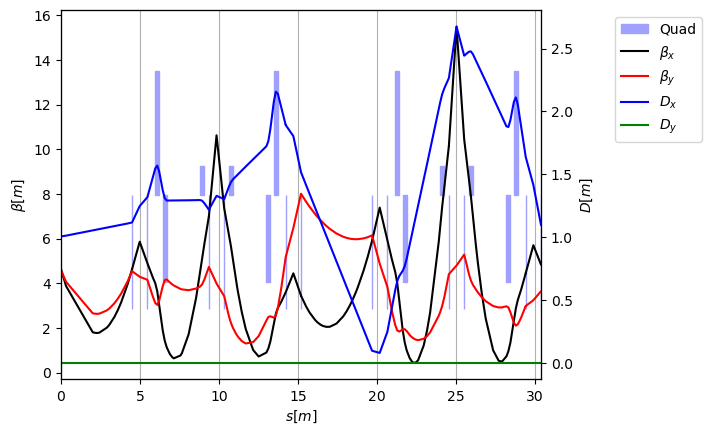

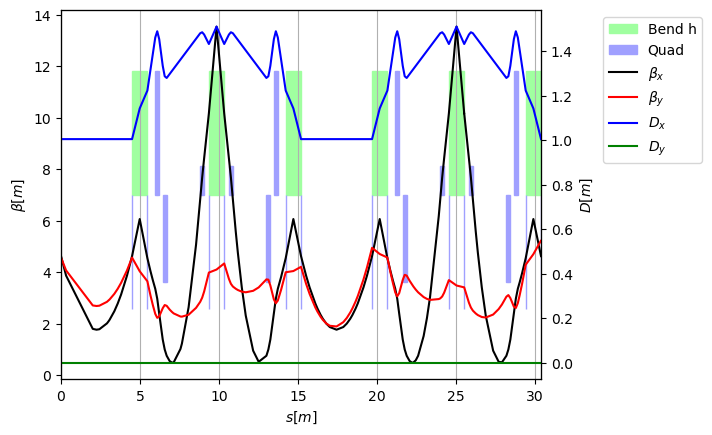

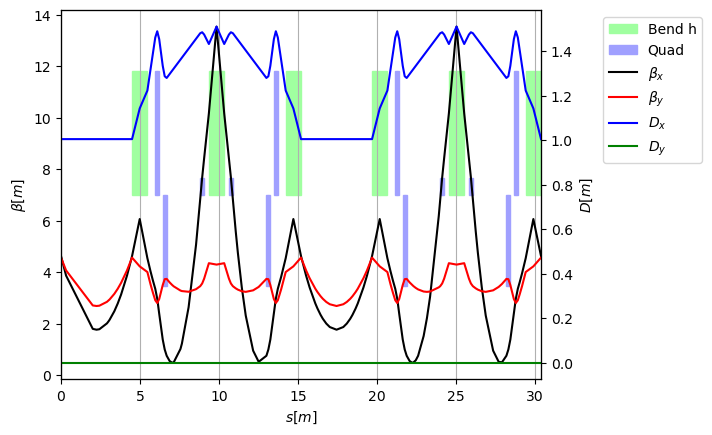

In [49]:
tw_not_rematched_mydipole.plot()
tw_not_rematched_without_fint.plot()
tw.plot()

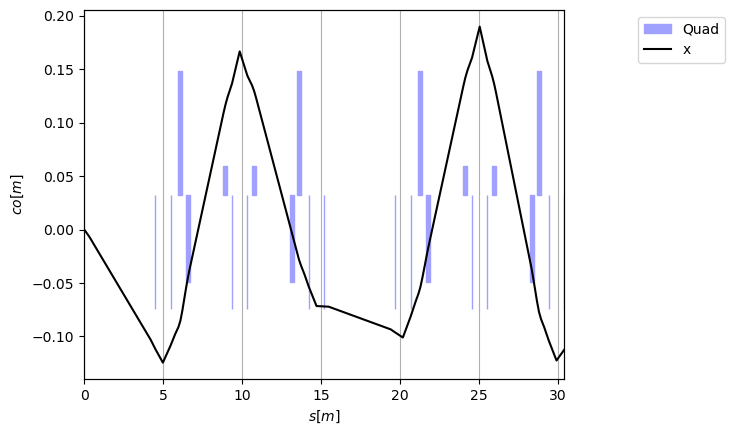

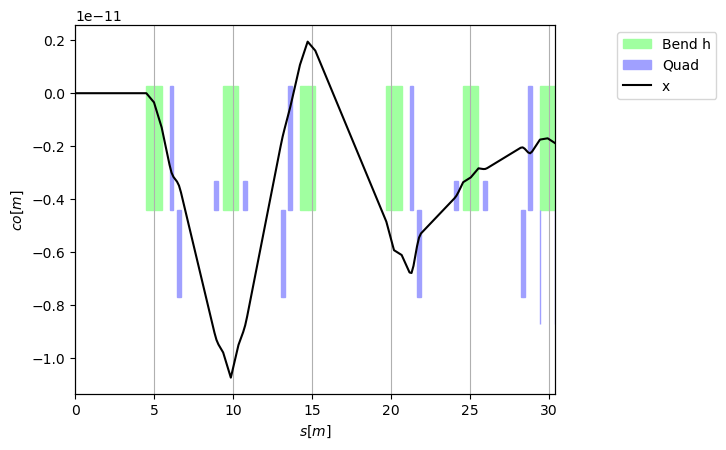

In [38]:
tw_not_rematched_mydipole.plot("x")
tw_not_rematched_without_fint.plot("x")

In [39]:
Dipoles:  
"lnr.mbhek.0135", "lnr.mbhek.0245", "lnr.mbhek.0335", "lnr.mbhek.0470", "lnr.mbhek.0560", "lnr.mbhek.0640"

SyntaxError: invalid syntax (2038406152.py, line 1)